In [1]:
using JLD2
using LinearAlgebra
using PyPlot
using StatsBase # Statistics
using Distributions
using PyCall
using ScikitLearn # machine learning package
@sk_import gaussian_process : GaussianProcessRegressor
@sk_import gaussian_process.kernels : Matern

# config plot settings
rcParams = PyPlot.PyDict(PyPlot.matplotlib."rcParams")
rcParams["font.size"] = 16;

In [2]:
###
#  Load data
###
@load joinpath(pwd(), "targets_and_normalized_features.jld2") X henry_y gcmc_y henry_total_elapsed_time gcmc_elapsed_time

5-element Vector{Symbol}:
 :X
 :henry_y
 :gcmc_y
 :henry_total_elapsed_time
 :gcmc_elapsed_time

## BO Function

In [3]:
### procedure:
# 1. select initial COF identifiers set to train GP 
# 2. initialize and normalize array of initial target data 
# 3. itterate through budgetted number of BO runs
#    a. construct GP model with kernel
#    b. fit GP to current data for acquired COFs => gives ŷ(x)
#    c. construct acquiaition function A(x)
#    d. determine which COF to acquire next => evaluate argmax(A(x))
#       i. for EI track if this is an exploitation or an exploration
#    e. append COF identified in step 3.d to list of acquired COFs 
# 4. update final set of acquired COF data and normalize
# 5. return the IDs for the set of acquired COFs
###
"""
# Arguments
- `X`: feature matrix
- `y`: target vector
- `nb_iterations`: maximum number of BO iterations (experiment budget)
- `which_acquisition`: which acquisition function to implement
` `store_explore_exploit_terms`: whether or not to keep track of the explore and exploit 
                                 terms from the acqisition for the acquired material at each iteration
- `sample_gp`: whether or not to store sample GP functions
- `initialize_with`: specify which and/or how many materials to initialize the search
- `kwargs`: dictionary of optional keyword arguments
"""
function run_bayesian_optimization(X, y, nb_iterations::Int, 
                                   nb_COFs_initialization::Int;
                                   which_acquisition::Symbol=:UCB,
                                   store_explore_exploit_terms::Bool=false,
                                   sample_gp::Bool=false,
                                   initialize_with::Union{Array{Int, 1}, Nothing}=nothing,
                                   kwargs::Dict{Symbol, Any}=Dict{Symbol, Any}())
    # quick checks
    @assert nb_iterations > nb_COFs_initialization "More initializations than itterations not allowed."
    @assert which_acquisition in [:UCB, :EI] "Acquisition function not supported:\t $(which_acquisition)"
    
    # create array to store explore-explot terms if needed
    if store_explore_exploit_terms
        explore_exploit_balance = []
    end
    
    if sample_gp
        store_sample_y = []
    end
    
    normal = Normal()
    
    ###
    #  1. randomly select COF IDs for training initial GP
    ###
    if isnothing(initialize_with)
        ids_acquired = StatsBase.sample(1:nb_COFs, nb_COFs_initialization, replace=false)
        @assert length(unique(ids_acquired)) == nb_COFs_initialization
    else
        # initialize using a specified set of indecies
        ids_acquired = initialize_with
        @assert length(unique(ids_acquired)) == nb_COFs_initialization
    end
     
    ###
    #  3. itterate through budgetted number of BO runs
    ###
    for i in range(nb_COFs_initialization, stop=nb_iterations-1) 
        ###
        #  a-b. construct and fit GP model
        ###
        kernel = Matern(nu=2.5, length_scale=0.25) 
        model = GaussianProcessRegressor(kernel=kernel, normalize_y=true, n_restarts_optimizer=5)
        model.fit(X[ids_acquired, :], y[ids_acquired]) #train model on acquired data
        
        if sample_gp
            sample_y = model.sample_y(X)
            push!(store_sample_y, sample_y)
        end
        
        ŷ, σ = model.predict(X, return_std=true)

        
        ###
        #  c. setup acquisition function
        ###
        if which_acquisition == :UCB
            # A(x) = ŷ(x) + βσ(x)
            # where β controlls exploitation-exploration trade-off
            β = 2.0
            acquisition_values = ŷ .+ β * σ
        elseif which_acquisition == :EI
            # A(x) = integral{-∞}{+∞}[I(x)N(y|ŷ(x), σ²(x))dy]
            # where I(x) = max(0, f(x) - maxᵢ(yᵢ))
            if any(σ .== 0.0)
                acquisition_values = zeros(length(σ))
            else
                y_max = maximum(y[ids_acquired])
                z = (ŷ .- y_max) ./ σ
                
                exploit_term = (ŷ .- y_max) .* cdf(normal, z) 
                explore_term = σ .* pdf(normal, z)
                
                acquisition_values = exploit_term .+ explore_term
            end
        end
        
        ###
        #  d. determine which COF to acquire next
        ###
        ids_sorted_by_aquisition = sortperm(acquisition_values, rev=true)
        for id_max_aquisition in ids_sorted_by_aquisition
            if ! (id_max_aquisition in ids_acquired)
                ###
                #  e. acqurie this COF (i.e. update list)
                ###
                push!(ids_acquired, id_max_aquisition)
                if store_explore_exploit_terms
                    # store explore and exploit terms
                    if which_acquisition == :UCB
                        push!(explore_exploit_balance, 
                              [ŷ[id_max_aquisition], β * σ[id_max_aquisition]])
                    elseif which_acquisition == :EI
                        push!(explore_exploit_balance, 
                              [exploit_term[id_max_aquisition], explore_term[id_max_aquisition]])
                    end
                end
                break
            end
        end
        # quick check
        @assert length(ids_acquired) == i + 1
    end
    
    # quick check (remember to account for final COF to be acquired)
    @assert length(ids_acquired) == nb_iterations "length(ids_acquired) = $(length(ids_acquired))"
    
    ###
    #  5. return the IDs for the set of acquired COFs
    ###
    if sample_gp
        return ids_acquired, explore_exploit_balance, store_sample_y
    else
        return ids_acquired, explore_exploit_balance
    end
end

run_bayesian_optimization

In [4]:
###
#  Find COF located nearest the center of the feature space
###
function get_initializing_COF(X)
    min = sum(ones(Float64, length(X[1, :]))) # max possible value of normalized features
    id_min = 0
    com = 0.5 * ones(Float64, length(X[1, :])) # center of normalized feature space

    for i in 1:length(X[:, 1])
        dist = sqrt(sum((X[i, :] .- com).^2))
        if dist < min
            min = dist
            id_min = i
        end
    end
    return id_min
end

# function diverse_set(X, train_size)
#     # initialize with one random point; pick others in a max diverse fashion
#     ids_train = [get_initializing_COF(X)]
#     # select remaining training points
#     for j in 1:train_size
#         # for each point in data set, compute its min dist to training set
#         dist_to_train_set = norm.(X .- X[ids_train, :])
#         min_dist_to_a_training_pt = minimum(dist_to_train_set)
#         # acquire point with max(min distance to train set) i.e. Furthest from train set
#         push!(ids_train, argmax(min_dist_to_a_training_pt))
#     end
#     return ids_train
# end

# nb_COFs = 608
# # ids_train = [26, 495, 524]
# train_size = 3
# ids_train = [get_initializing_COF(X)]
# for h in 1:train_size-1
# #     val = ids_train[h]
#     q = [X .- X[[ids_train[i]], :] for i in 1:h]
#     p = [[norm(q[i][k, :]) for k in 1:nb_COFs] for i in 1:h]
#     m = minimum(p, dims=2)[1]
#     n = argmax(m)
#     push!(ids_train, n)
# end
# ids_train

get_initializing_COF (generic function with 1 method)

## Apply BO

In [5]:
nb_COFs = length(gcmc_y)
nb_iterations = 100
nb_COFs_initialization = 3 # 
which_acquisition = :EI # :UCB or :EI 

# try to initialize using a COF that is close to the center of the domain (feature space)
# initialize_with = 
initialize_with = [26, 495, 524] # diverse_set(X, train_size) #[get_initializing_COF(X)]

3-element Vector{Int64}:
  26
 495
 524

In [6]:
acq_ids, eeb = run_bayesian_optimization(X, gcmc_y, nb_iterations, 
                                         nb_COFs_initialization;
                                         which_acquisition=which_acquisition,
                                         store_explore_exploit_terms=true,
                                         sample_gp=false,
                                         initialize_with=initialize_with);

In [7]:
acq_max_id = findfirst(acq_ids .== findfirst(gcmc_y .== maximum(gcmc_y)))

20

In [8]:
sum(gcmc_elapsed_time[acq_ids[1:acq_max_id]])

4897.9533317526175

## Do a Random Search

In [9]:
###
#  Get Samples
###
nb_runs = 100

rs_res = Dict{String, Array{Array{Float64, 1}, 1}}()
rs_res["rs_cofs_acquired"] = []
for i in range(1, stop=nb_runs)
    ids = StatsBase.sample(1:nb_COFs, nb_iterations, replace=false)
    push!(rs_res["rs_cofs_acquired"], gcmc_y[ids])
end

###
#  Determine the distribution from random search
###
function random_search_dist(res::Dict)
    # initialize arrays
    rs_up_bnd = zeros(nb_iterations)
    rs_mean   = zeros(nb_iterations)
    rs_lw_bnd = zeros(nb_iterations)
    
    
    for n in 1:nb_iterations
        # max value acquired up to this point
        y_max = [maximum(rs_res["rs_cofs_acquired"][r][1:n]) for r in 1:nb_runs]
        @assert length(y_max) == nb_runs
        rs_mean[n]   = mean(y_max)
        rs_up_bnd[n] = std(y_max[y_max .> rs_mean[n]])
        rs_lw_bnd[n] = std(y_max[y_max .< rs_mean[n]])
    end
    
    return rs_mean, rs_up_bnd, rs_lw_bnd
end

rs_mean, rs_upper_bound, rs_lower_bound = random_search_dist(rs_res);

## Plot: search efficiency curve

In [10]:
# plot maximum selectivity among acquired COFs as a function of the number of COFs acquired (itterations)
# plot accumulated cost as a function of the number of COFs acquired (itterations)
index = zeros(Int64, length(acq_ids))
max_selectivity = zeros(Float64, length(acq_ids))
acq_cost = zeros(Float64, length(acq_ids))

for i in 1:length(acq_ids)
    ids = acq_ids[1:i]
    
    acq_cost[i] = sum(gcmc_elapsed_time[ids])
    
    max_y = maximum(gcmc_y[ids])
    max_selectivity[i] = max_y
    
    index[i] = i
end

In [11]:
fig, axs = subplots(2, sharex=true, figsize=(8, 8))
# cost
axs[1].axvline(x=nb_COFs_initialization, label="initialization", color="tab:grey", linestyle="--", lw=2)
axs[1].plot(index, acq_cost, label="cost", color="tab:blue", lw=2)
# axs[1].set_title("Single-fidelity Bayesian Optimization")
axs[1].legend(loc="lower right", fontsize=12)
axs[1].set_ylabel("accumulated cost [min]")
axs[1].set_xlim([0.0, nb_iterations])
axs[1].set_ylim([0.0, 25000])

# search efficiency
axs[2].axvline(x=nb_COFs_initialization, label="initialization", color="tab:grey", linestyle="--", lw=2)
axs[2].axhline(y=maximum(gcmc_y), label="global maximm", color="tab:green", ls="--", lw=1.5)
axs[2].plot(index, max_selectivity, label="BO", color="tab:blue", lw=2)

axs[2].plot(index, rs_mean, label="random search", color="tab:orange", lw=2)
axs[2].fill_between(index, rs_mean .- rs_lower_bound, rs_mean .+ rs_upper_bound, 
    color="tab:orange", hatch="/", alpha=0.15)

# axs[2].title("Acquisition function: $(string(which_acquisition))", fontsize=14)
axs[2].legend(loc="lower right", fontsize=12)
axs[2].set_xlabel("# evaluated COFs")
axs[2].set_ylabel("max. " * L"S_{Xe/Kr}" * " acquired")
axs[2].set_ylim(ymin=0, ymax=20)

tight_layout()
savefig(joinpath(pwd(), "figs", 
        "search_efficientcy_curve_$(string(which_acquisition)).pdf"), dpi=600, format="pdf")
savefig(joinpath(pwd(), "figs", 
        "search_efficientcy_and_cost_curve_$(string(which_acquisition)).png"), dpi=600, format="png")

LoadError: InterruptException:

### Elxploration-Exploitation 

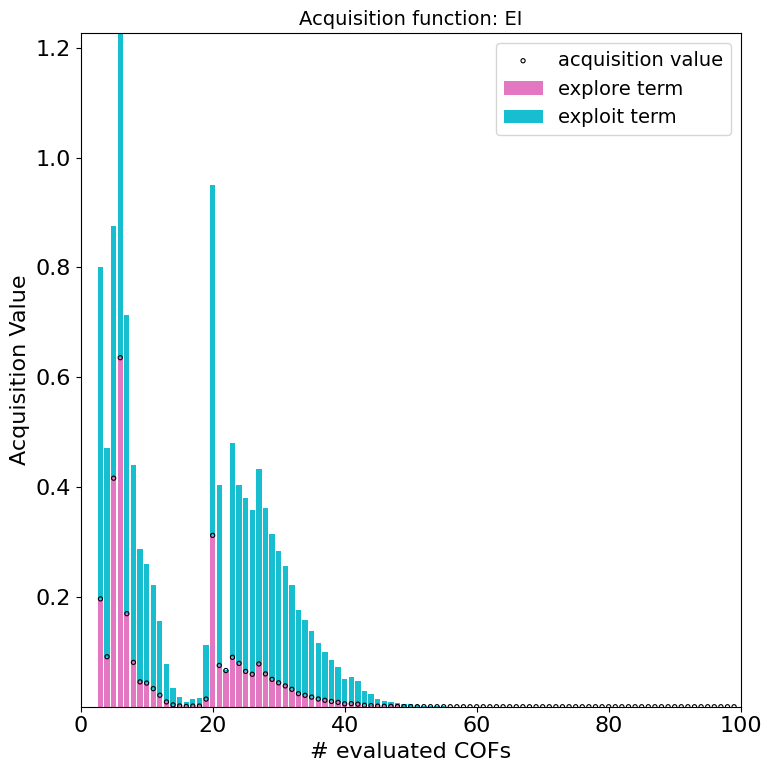

In [12]:
# make a plot of ŷ and σ as a function of itterations to see exploitation vs exploration
fig, axs = subplots(figsize=(8, 8))

index = [i for i in nb_COFs_initialization:nb_iterations-1]
exploit = [eeb[i][1] for i in 1:length(eeb)]
explore = [eeb[i][2] for i in 1:length(eeb)]

axs.bar(index, explore, label="explore term", color="tab:pink")
axs.bar(index, exploit, label="exploit term", color="tab:cyan", 
        ls="--", bottom=explore)

axs.scatter(index, exploit .+ explore, label="acquisition value", 
            marker=".", facecolor="none", edgecolor="k", lw=0.8, zorder=2)

axs.set_xlim([0, 100])
title("Acquisition function: $(string(which_acquisition))", fontsize=14)
axs.legend(fontsize=14)
axs.set_xlabel("# evaluated COFs")
axs.set_ylabel("Acquisition Value")


tight_layout()
savefig(joinpath(pwd(), "figs", 
        "exploration_exploitation_balance_$(string(which_acquisition)).png"), dpi=600, format="png")